In [1]:
import numpy as np
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import umap
import math
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib import colors
import matplotlib.transforms as mtrans
import yaml
from yaml.loader import SafeLoader
from collections import OrderedDict
#from verstack.stratified_continuous_split import scsplit
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR, SVC
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import seaborn as sns
import random as rd

/neurospin/dico/jlaval/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Release3 dHCP : select subjects from info dataframe

dir_Release3 = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/denis/release3_scripts/subjects_file_v4.json'
with open(dir_Release3) as f:
    subjects_R3 = json.load(f)

subjects_R3 = list(subjects_R3.keys())

# get the session ids of R3
dir_sessions = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/denis/release3_scripts/subjects_file_v4.json'
with open(dir_sessions) as f:
    dict_sessions = json.load(f)
sessions = [value['session_id'] for _, value in dict_sessions.items()]

# get dHCP info
dir_info_dHCP = '/home/jl274628/Documents/info_dHCP.tsv'
info_dHCP = pd.read_csv(dir_info_dHCP, usecols=['participant_id', 'birth_age', 'scan_age', 'session_id'], sep='\t')
# filter over subjects
info_dHCP.drop(info_dHCP[~(info_dHCP['participant_id'].isin(subjects_R3))].index, inplace = True)
#info_dHCP.drop(info_dHCP[(info_dHCP['scan_number']!=1)].index, inplace = True) # not always scan 1
# filter over sessions
info_dHCP.drop(info_dHCP[~(info_dHCP['session_id'].isin(sessions))].index, inplace = True)
info_dHCP.reset_index(drop=True, inplace=True)

In [3]:
def plot_umap(df, label, thresholds, colors, ax, title, fontsize=15, AUC=(0,0), transparency_full_term=0.3, scatter_size=None):

    dims = ['dim1', 'dim2']

    # plot in decreasing label order
    df_sliced = df.loc[df[label] > thresholds[-1]]
    umap = df_sliced[dims]
    ax.scatter(umap['dim1'], umap['dim2'], label = f'{label} > {thresholds[-1]}', alpha=transparency_full_term, color=colors[-1], s=scatter_size)

    for idx in range(len(thresholds)-1, 0, -1):

        df_sliced = df.loc[(df[label] <= thresholds[idx]) & (df[label] > thresholds[idx-1])]
        umap = df_sliced[dims]
        ax.scatter(umap['dim1'], umap['dim2'], label = f'{thresholds[idx-1]} < {label} < {thresholds[idx]}', color=colors[idx], s=scatter_size)

    df_sliced = df.loc[df[label] <= thresholds[0]]
    umap = df_sliced[dims]
    ax.scatter(umap['dim1'], umap['dim2'], label = f'{label} < {thresholds[0]}', color=colors[0], s=scatter_size)

    #ax.set_title(f'UMAP on dHCP (AUC: {AUC[0]:.2f} - {AUC[1]:.2f})')
    ax.set_title(title, fontsize=fontsize)
    leg = ax.legend(fontsize=fontsize)
    for i, lh in enumerate(leg.legendHandles):
        if i==0:
            lh.set_alpha(0.5)
        else:
            lh.set_alpha(1)

In [21]:
model = "15-49-36_1"
#model = 09-59-38_188
save_dir = f'/home/jl274628/Documents/PLOT_RAPPORT/STS_UKB_models/{model}/'
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

# load embeddings UKB
#dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-15/14-36-49/STs_UkBioBank_embeddings/'
dir = f'/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/{model}/UKB_embeddings/'
dir_embeddings = dir+'full_embeddings.csv'

cols = [f'dim{k}' for k in range(1,11)]
df_embeddings = pd.read_csv(dir_embeddings, sep=',')
all_1 = df_embeddings[cols]
# add embeddings dHCP
#dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-15/14-36-49/STs_dHCP_374_subjects_embeddings/'
dir = f'/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/{model}/dHCP_embeddings/'

dir_embeddings = dir+'full_embeddings.csv'

df_embeddings = pd.read_csv(dir_embeddings, sep=',')
all_2 = df_embeddings[cols]

all = pd.concat((all_1, all_2))
all = all.to_numpy()
#all = scaler.fit_transform(all)

# retreive scaled datasets
all_1 = all[:len(all_1)]
all_2 = all[len(all_1):]

all_1 = pd.DataFrame(all_1)
all_1.columns=cols
all_2 = pd.DataFrame(all_2)
all_2.columns=cols

ukb_fit=True

# fit UMAP
reducer = umap.UMAP(random_state=42) #random_state=42
if ukb_fit:
    embeddings = reducer.fit_transform(all_1)
    df_embeddings_0 = pd.DataFrame({'dim1': embeddings[:, 0],
                                    'dim2': embeddings[:, 1]})

    embeddings = reducer.transform(all_2)
    df_embeddings_1 = pd.DataFrame({'participant_id': df_embeddings['ID'].tolist(),
                                'dim1': embeddings[:, 0],
                                'dim2': embeddings[:, 1]})
    # merge with labels (birth age)
    df = pd.merge(info_dHCP, df_embeddings_1)
else: #dHCP fit
    embeddings = reducer.fit_transform(all_2)
    df_embeddings_1 = pd.DataFrame({'participant_id': df_embeddings['ID'].tolist(),
                                'dim1': embeddings[:, 0],
                                'dim2': embeddings[:, 1]})
    embeddings = reducer.transform(all_1)
    df_embeddings_0 = pd.DataFrame({'dim1': embeddings[:, 0],
                                    'dim2': embeddings[:, 1]})
    df = pd.merge(info_dHCP, df_embeddings_1)

/neurospin/dico/jlaval/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/tmp/ipykernel_797789/4242408200.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i, lh in enumerate(leg.legendHandles):


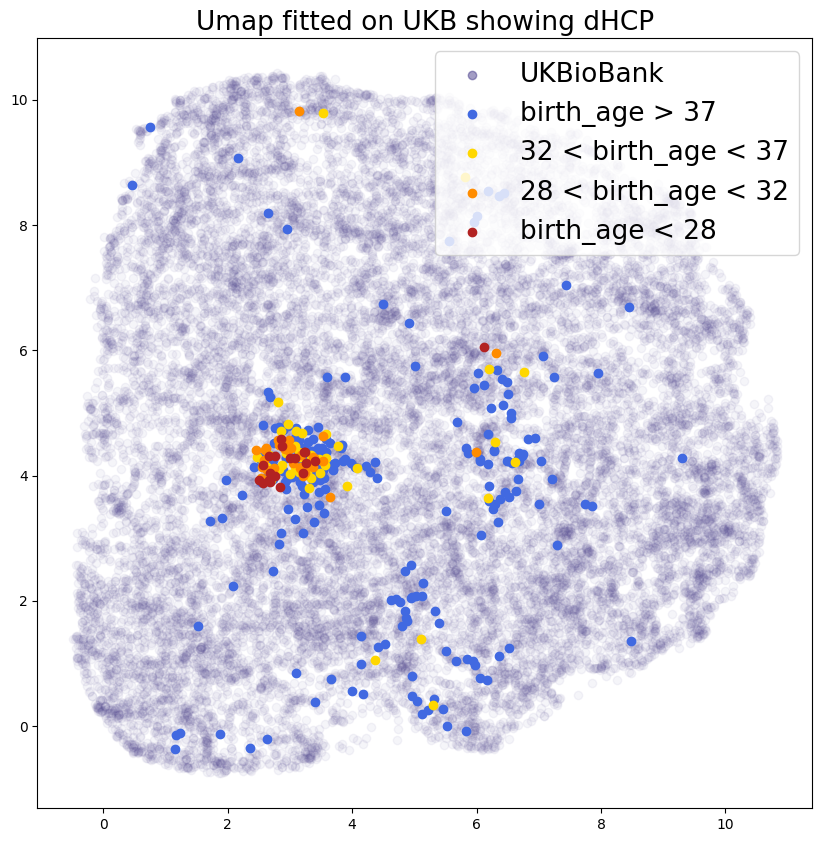

In [22]:
#split preterm and not preterm
label='birth_age'
#thresholds=[37,34,32,30,28]
thresholds=[28,32,37]
colors=['firebrick', 'darkorange', 'gold','royalblue']

fig, ax = plt.subplots(figsize=(10,10))


if ukb_fit:
    fit=''
    plt.scatter(df_embeddings_0['dim1'], df_embeddings_0['dim2'], color='darkslateblue', label='UKBioBank', alpha=0.05)
else:
    fit='-fit_on_dHCP'

plot_umap(df, label, thresholds, colors, ax, title='Umap fitted on UKB showing dHCP', fontsize=19, transparency_full_term=1)

plt.savefig(save_dir+f'UMAP_UKB_dHCP{fit}.png')
plt.show()

In [11]:
# select only the most preterm, and compare to utrecht individuals

### WOULD BE BETTER TO IMPLEMENT A FUNCTION THAN MANY COPY PASTE

# load embeddings dHCP
dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-15/14-36-49/STs_dHCP_374_subjects_embeddings/'
dir_embeddings = dir+'full_embeddings.csv'
df_embeddings = pd.read_csv(dir_embeddings, sep=',')
df_embeddings.columns=['participant_id']+cols
dHCP = pd.merge(info_dHCP, df_embeddings)
dHCP_embeddings = dHCP[dHCP['birth_age']<28]
dHCP_embeddings = dHCP_embeddings[cols]
dHCP_26_31_embeddings = dHCP[(dHCP['birth_age']<31)&(dHCP['birth_age']>26)]
dHCP_26_31_embeddings = dHCP_26_31_embeddings[cols]

#load utrecht embeddings
dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-15/14-36-49/STs_utrecht_dhcp_morpho_embeddings/'
dir_embeddings = dir+'full_embeddings.csv'
df_embeddings = pd.read_csv(dir_embeddings, sep=',')
utrecht_embeddings = df_embeddings[cols]

#load old utrecht embeddings
dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-15/14-36-49/STs_utrecht_40wks_embeddings/'
dir_embeddings = dir+'full_embeddings.csv'
df_embeddings = pd.read_csv(dir_embeddings, sep=',')
utrecht_embeddings_old = df_embeddings[cols]

#add UKB embeddings
dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-15/14-36-49/STs_UkBioBank_embeddings/'
dir_embeddings = dir+'full_embeddings.csv'
df_embeddings = pd.read_csv(dir_embeddings, sep=',')
UKB_embeddings = df_embeddings[cols]

#add Geneva Preterm
dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-15/14-36-49/STs_PretermMusicGeneva_2019_embeddings/'
dir_embeddings = dir+'train_val_embeddings.csv'
df_embeddings = pd.read_csv(dir_embeddings, sep=',')
geneva_embeddings = df_embeddings[cols]

In [12]:
# scale all data together
all = pd.concat((dHCP_embeddings, utrecht_embeddings, UKB_embeddings))
all = all.to_numpy()
#all = scaler.fit_transform(all)

# retreive scaled datasets
dHCP_embeddings_scaled = all[:len(dHCP_embeddings)]
utrecht_embeddings_scaled = all[len(dHCP_embeddings):-len(UKB_embeddings)]
UKB_embeddings_scaled = all[-len(UKB_embeddings):]

# fit UMAP on UKB
#reducer = umap.UMAP()
embeddings = reducer.transform(UKB_embeddings_scaled)
df_embeddings_0 = pd.DataFrame({'dim1': embeddings[:, 0],
                                'dim2': embeddings[:, 1]})

embeddings = reducer.transform(dHCP_embeddings_scaled)
df_embeddings_1 = pd.DataFrame({'dim1': embeddings[:, 0],
                                'dim2': embeddings[:, 1]})
embeddings = reducer.transform(utrecht_embeddings_scaled)
df_embeddings_2 = pd.DataFrame({'dim1': embeddings[:, 0],
                                'dim2': embeddings[:, 1]})

/tmp/ipykernel_797789/682968255.py:9: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i, lh in enumerate(leg.legendHandles):


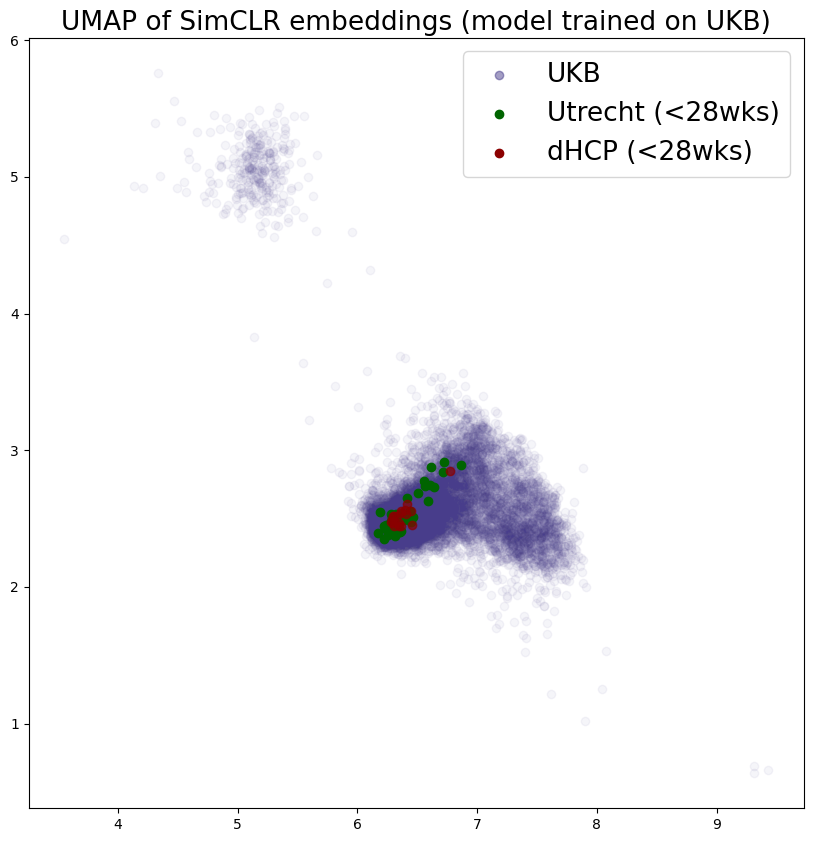

In [8]:
fig, ax = plt.subplots(figsize=(10,10))

dims = ('dim1', 'dim2')
ax.scatter(df_embeddings_0['dim1'], df_embeddings_0['dim2'], label = f'UKB', alpha=0.05, color='darkslateblue')
ax.scatter(df_embeddings_2['dim1'], df_embeddings_2['dim2'], label = f'Utrecht (<28wks)', alpha=1, color='darkgreen')
ax.scatter(df_embeddings_1['dim1'], df_embeddings_1['dim2'], label = f'dHCP (<28wks)', alpha=0.7, color='darkred')
plt.title('UMAP of SimCLR embeddings (model trained on UKB)',fontsize=19)
leg = plt.legend(fontsize=19)
for i, lh in enumerate(leg.legendHandles):
    if i==0:
        lh.set_alpha(0.5)
    else:
        lh.set_alpha(1)
plt.savefig(save_dir+'umap_ukb_utrecht_dhcp.png', facecolor='white')
plt.show()

#Utrecht and other databases

In [ ]:
# plot the same UMAP, but subsample utrecht at 19 subjects
subsample = 19
fig, ax = plt.subplots(figsize=(12,12))

dims = ('dim1', 'dim2')
ax.scatter(df_embeddings_0['dim1'], df_embeddings_0['dim2'], label = f'UKB', alpha=0.1, color='darkslateblue')
df_embeddings_2_sub = df_embeddings_2.sample(subsample)
ax.scatter(df_embeddings_2_sub['dim1'], df_embeddings_2_sub['dim2'], label = f'utrecht (<28wks)', alpha=1, color='darkgreen')
ax.scatter(df_embeddings_1['dim1'], df_embeddings_1['dim2'], label = f'dHCP (<28wks)', alpha=0.7, color='darkred')
plt.title('UMAP of SimCLR embeddings (model trained on UKB)')
plt.legend()
plt.savefig(save_dir+'umap_ukb_utrecht_dhcp_subsample.png', facecolor='white')
plt.show()

In [ ]:
all = pd.concat((dHCP_embeddings, utrecht_embeddings, utrecht_embeddings_old, UKB_embeddings))
all = all.to_numpy()
#all = scaler.fit_transform(all)

# retreive scaled datasets
dHCP_embeddings_scaled = all[:len(dHCP_embeddings)]
utrecht_embeddings_scaled = all[len(dHCP_embeddings):len(dHCP_embeddings)+len(utrecht_embeddings)]
utrecht_old_embeddings_scaled = all[len(dHCP_embeddings)+len(utrecht_embeddings):-len(UKB_embeddings)]
UKB_embeddings_scaled = all[-len(UKB_embeddings):]

# fit UMAP on UKB
#reducer = umap.UMAP()
embeddings = reducer.transform(UKB_embeddings_scaled)
df_embeddings_0 = pd.DataFrame({'dim1': embeddings[:, 0],
                                'dim2': embeddings[:, 1]})

embeddings = reducer.transform(dHCP_embeddings_scaled)
df_embeddings_1 = pd.DataFrame({'dim1': embeddings[:, 0],
                                'dim2': embeddings[:, 1]})
embeddings = reducer.transform(utrecht_embeddings_scaled)
df_embeddings_2 = pd.DataFrame({'dim1': embeddings[:, 0],
                                'dim2': embeddings[:, 1]})
embeddings = reducer.transform(utrecht_old_embeddings_scaled)
df_embeddings_3 = pd.DataFrame({'dim1': embeddings[:, 0],
                                'dim2': embeddings[:, 1]})

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))

dims = ('dim1', 'dim2')
ax.scatter(df_embeddings_0['dim1'], df_embeddings_0['dim2'], label = f'UKB', alpha=0.1, color='darkslateblue')
ax.scatter(df_embeddings_2['dim1'], df_embeddings_2['dim2'], label = f'utrecht', alpha=1, color='darkgreen')
ax.scatter(df_embeddings_3['dim1'], df_embeddings_3['dim2'], label = f'utrecht old segmentation', alpha=0.7, color='darkred')
plt.title('UMAP of SimCLR embeddings (model trained on UKB)')
plt.legend(fontsize=14)
plt.savefig(save_dir+'umap_ukb_utrecht_utrecht_old.png', facecolor='white')
plt.show()

In [ ]:
# scale all data together
all = pd.concat((geneva_embeddings,UKB_embeddings))
all = all.to_numpy()
#all = scaler.fit_transform(all)

# retreive scaled datasets
geneva_embeddings_scaled = all[:len(geneva_embeddings)]
UKB_embeddings_scaled = all[-len(UKB_embeddings):]

# fit UMAP on UKB
#reducer = umap.UMAP()
embeddings = reducer.transform(UKB_embeddings_scaled)
df_embeddings_0 = pd.DataFrame({'dim1': embeddings[:, 0],
                                'dim2': embeddings[:, 1]})

embeddings = reducer.transform(geneva_embeddings_scaled)
df_embeddings_1 = pd.DataFrame({'dim1': embeddings[:, 0],
                                'dim2': embeddings[:, 1]})

In [ ]:
df_geneva = pd.read_csv('/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-15/14-36-49/STs_PretermMusicGeneva_2019_embeddings/full_embeddings.csv')
labels = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/PretermMusicGeneva_2019/crops/2mm/S.T.s.baby/mask/music_labels.csv')
labels.columns=['ID', 'music']
labels = pd.merge(df_geneva, labels)['music'].to_numpy()

fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(df_embeddings_0['dim1'], df_embeddings_0['dim2'], label = f'UKB', alpha=0.1, color='darkslateblue')
ax.scatter(df_embeddings_1['dim1'].to_numpy()[np.where(labels)], df_embeddings_1['dim2'].to_numpy()[np.where(labels)], label = f'Geneva with music', alpha=1, color='darkred')
ax.scatter(df_embeddings_1['dim1'].to_numpy()[np.where(1-labels)], df_embeddings_1['dim2'].to_numpy()[np.where(1-labels)], label = f'Geneva no music', alpha=1, color='darkgreen')
plt.title('UMAP of SimCLR embeddings (model trained on UKB)')
plt.legend(fontsize=14)
plt.savefig(save_dir+'umap_ukb_geneva_music.png', facecolor='white')
plt.show()

In [ ]:
# scale all data together
all = pd.concat((geneva_embeddings,dHCP_26_31_embeddings,UKB_embeddings))
all = all.to_numpy()
#all = scaler.fit_transform(all)

# retreive scaled datasets
geneva_embeddings_scaled = all[:len(geneva_embeddings)]
dHCP_26_31_embeddings_scaled = all[len(geneva_embeddings):len(geneva_embeddings)+len(dHCP_26_31_embeddings)]
UKB_embeddings_scaled = all[-len(UKB_embeddings):]

# fit UMAP on UKB
#reducer = umap.UMAP()
embeddings = reducer.transform(UKB_embeddings_scaled)
df_embeddings_0 = pd.DataFrame({'dim1': embeddings[:, 0],
                                'dim2': embeddings[:, 1]})

embeddings = reducer.transform(geneva_embeddings_scaled)
df_embeddings_1 = pd.DataFrame({'dim1': embeddings[:, 0],
                                'dim2': embeddings[:, 1]})
embeddings = reducer.transform(dHCP_26_31_embeddings_scaled)
df_embeddings_2 = pd.DataFrame({'dim1': embeddings[:, 0],
                                'dim2': embeddings[:, 1]})

In [ ]:
# Geneva is between 26 and 31 weeks
# select same age range in dHCP

fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(df_embeddings_0['dim1'], df_embeddings_0['dim2'], label = f'UKB', alpha=0.1, color='darkslateblue')
ax.scatter(df_embeddings_1['dim1'], df_embeddings_1['dim2'], label = f'Geneva', alpha=1, color='darkred')
ax.scatter(df_embeddings_2['dim1'], df_embeddings_2['dim2'], label = f'dHCP (26-31wks)', alpha=1, color='darkgreen')
plt.title('UMAP of SimCLR embeddings (model trained on UKB)')
plt.legend(fontsize=14)
plt.savefig(save_dir+'umap_ukb_geneva_dhcp_26_31.png', facecolor='white')
plt.show()

In [ ]:
# same but all databases at once
all = pd.concat((dHCP_embeddings, utrecht_embeddings, geneva_embeddings, UKB_embeddings))
all = all.to_numpy()
#all = scaler.fit_transform(all)

# retreive scaled datasets
dHCP_embeddings_scaled = all[:len(dHCP_embeddings)]
utrecht_embeddings_scaled = all[len(dHCP_embeddings):len(dHCP_embeddings)+len(utrecht_embeddings)]
geneva_embeddings_scaled = all[len(dHCP_embeddings)+len(utrecht_embeddings):-len(UKB_embeddings)]
UKB_embeddings_scaled = all[-len(UKB_embeddings):]

# fit UMAP on UKB
#reducer = umap.UMAP()
embeddings = reducer.transform(UKB_embeddings_scaled)
df_embeddings_0 = pd.DataFrame({'dim1': embeddings[:, 0],
                                'dim2': embeddings[:, 1]})

embeddings = reducer.transform(dHCP_embeddings_scaled)
df_embeddings_1 = pd.DataFrame({'dim1': embeddings[:, 0],
                                'dim2': embeddings[:, 1]})
embeddings = reducer.transform(utrecht_embeddings_scaled)
df_embeddings_2 = pd.DataFrame({'dim1': embeddings[:, 0],
                                'dim2': embeddings[:, 1]})
embeddings = reducer.transform(geneva_embeddings_scaled)
df_embeddings_3 = pd.DataFrame({'dim1': embeddings[:, 0],
                                'dim2': embeddings[:, 1]})

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))

dims = ('dim1', 'dim2')
ax.scatter(df_embeddings_0['dim1'], df_embeddings_0['dim2'], label = f'UKB', alpha=0.1, color='darkslateblue')
ax.scatter(df_embeddings_1['dim1'], df_embeddings_1['dim2'], label = f'dHCP (< 28 weeks)', alpha=1, color='darkblue')
ax.scatter(df_embeddings_2['dim1'], df_embeddings_2['dim2'], label = f'utrecht', alpha=1, color='darkgreen')
ax.scatter(df_embeddings_3['dim1'], df_embeddings_3['dim2'], label = f'geneva', alpha=1, color='darkred')
plt.title('UMAP of SimCLR embeddings (model trained on UKB)')
plt.legend(fontsize=14)
plt.savefig(save_dir+'umap_ukb_utrecht_dHCP_geneva.png', facecolor='white')
plt.show()